In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16  # Import a pre-trained model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np


In [3]:
# Set the paths to the directories
train_dir = 'Teeth_Dataset/Training'
val_dir = 'Teeth_Dataset/Validation'
test_dir = 'Teeth_Dataset/Testing'

# Load the datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

# Print the class names
class_names = train_ds.class_names
print("Class names:", class_names)


Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Class names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


In [4]:
for images, labels in train_ds.take(1):
    print("Train dataset batch:")
    print(f"Image shape: {images.shape}")
    print(f"Label shape: {labels.shape}")

for images, labels in val_ds.take(1):
    print("Validation dataset batch:")
    print(f"Image shape: {images.shape}")
    print(f"Label shape: {labels.shape}")


Train dataset batch:
Image shape: (32, 224, 224, 3)
Label shape: (32,)
Validation dataset batch:
Image shape: (32, 224, 224, 3)
Label shape: (32,)


In [5]:
# Normalize the datasets
def normalize_dataset(dataset):
    return dataset.map(lambda x, y: (x / 255.0, y))

train_ds = normalize_dataset(train_ds)
val_ds = normalize_dataset(val_ds)
test_ds = normalize_dataset(test_ds)




In [6]:
# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Apply data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Shuffle and prefetch the datasets
train_ds = train_ds.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [7]:
# Load the pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False




58889256/58889256 [==============================] - 27s 0us/step


In [8]:
base_model

In [9]:
# Add new classification layers on top of it
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])



In [10]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Set early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [11]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
97/97 [==============================] - 37s 142ms/step - loss: 2.4073 - accuracy: 0.3132 - val_loss: 1.3534 - val_accuracy: 0.5642
Epoch 2/10
97/97 [==============================] - 24s 110ms/step - loss: 1.4718 - accuracy: 0.4318 - val_loss: 1.1769 - val_accuracy: 0.6323
Epoch 3/10
97/97 [==============================] - 25s 110ms/step - loss: 1.3518 - accuracy: 0.4778 - val_loss: 1.1691 - val_accuracy: 0.6547
Epoch 4/10
97/97 [==============================] - 25s 110ms/step - loss: 1.2859 - accuracy: 0.5096 - val_loss: 1.0343 - val_accuracy: 0.6946
Epoch 5/10
97/97 [==============================] - 24s 110ms/step - loss: 1.2136 - accuracy: 0.5300 - val_loss: 0.9097 - val_accuracy: 0.7140
Epoch 6/10
97/97 [==============================] - 25s 110ms/step - loss: 1.1712 - accuracy: 0.5585 - val_loss: 0.8619 - val_accuracy: 0.7267
Epoch 7/10
97/97 [==============================] - 24s 110ms/step - loss: 1.1496 - accuracy: 0.5432 - val_loss: 0.8341 - val_accuracy: 0.7626

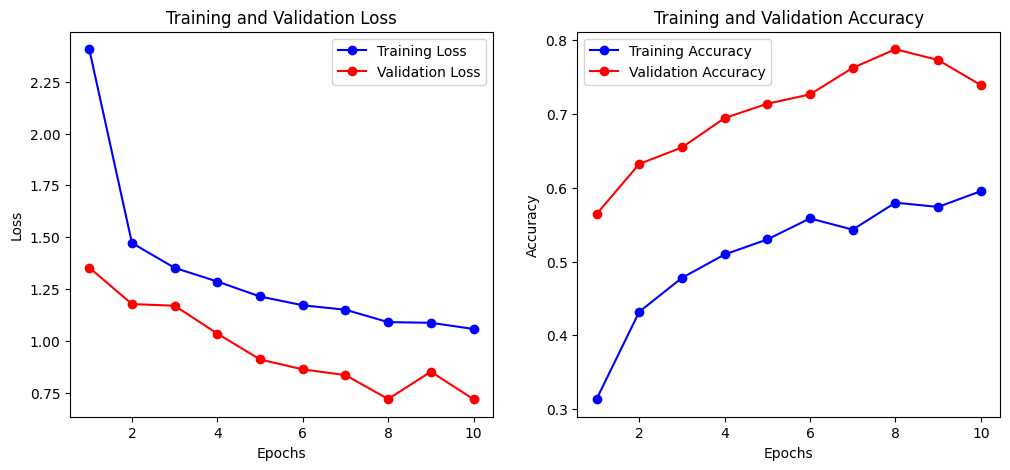

In [12]:
# Plot training & validation loss and accuracy
epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(12, 5))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [13]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')


33/33 [==============================] - 3s 85ms/step - loss: 0.7018 - accuracy: 0.7344
Test Loss: 0.7017849087715149
Test Accuracy: 0.7344357967376709


In [14]:
# Collect true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=-1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)



1/1 [==============================] - 0s 107ms/step


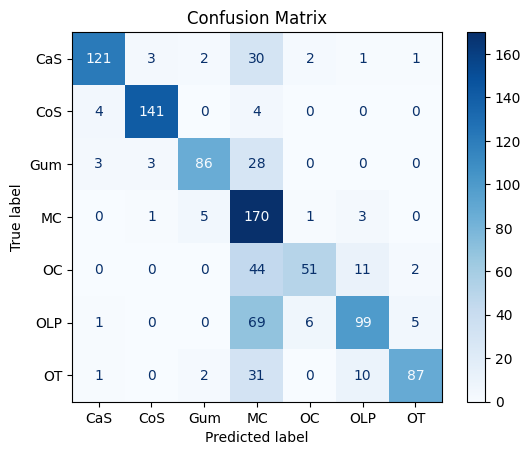

              precision    recall  f1-score   support

         CaS       0.93      0.76      0.83       160
         CoS       0.95      0.95      0.95       149
         Gum       0.91      0.72      0.80       120
          MC       0.45      0.94      0.61       180
          OC       0.85      0.47      0.61       108
         OLP       0.80      0.55      0.65       180
          OT       0.92      0.66      0.77       131

    accuracy                           0.73      1028
   macro avg       0.83      0.72      0.75      1028
weighted avg       0.81      0.73      0.74      1028



In [15]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


In [16]:
# Save the model
model.save("TeethClassification_finetuned.h5")

In [2]:
# Load the model
loaded_model = tf.keras.models.load_model('TeethClassification_finetuned.h5')

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the image
img_path = 'infere_img2.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model's input size

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Normalize the image array (scale pixel values to [0, 1])
img_array = img_array / 255.0

# Add a batch dimension (make it a 4D tensor)
img_array = np.expand_dims(img_array, axis=0)

# Verify the shape of the image
print(img_array.shape)  # Should be (1, 224, 224, 3)


(1, 224, 224, 3)


In [6]:
# Make predictions
predictions = loaded_model.predict(img_array)
class_names = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
# Get the predicted class
predicted_class = np.argmax(predictions, axis=-1)

# Map predicted class index to class name
predicted_class_name = class_names[predicted_class[0]]
print(f'Predicted Class: {predicted_class_name}')

1/1 [==============================] - 0s 21ms/step
Predicted Class: MC
